In [46]:
import torch
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np
import imageio
import seaborn as sns
from sklearn.manifold import TSNE
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda:0


In [47]:
class Generator(nn.Module):
    def __init__(self, z_dimension, number_features, number_channels, number_of_classes):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dimension + z_dimension, number_features * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(number_features * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(number_features * 4, number_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_features * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(number_features * 2, number_features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_features),
            nn.ReLU(True),
            nn.ConvTranspose2d(number_features, number_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        self.embed = nn.Embedding(number_of_classes, z_dimension)

    def forward(self, z, labels):
        embedding = self.embed(labels)  # Get embeddings for the labels
        # Reshape latent vector z to include batch size and spatial dimensions
        z = z.view(z.size(0), z.size(1), 1, 1)  # N x z_dim x 1 x 1
        z = torch.cat([z, embedding.unsqueeze(2).unsqueeze(3)], dim=1) 
        return self.main(z)
    
class Discriminator(nn.Module):
    def __init__(self, number_disc_features, number_channels, number_of_classes):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(in_channels=number_channels + 1, out_channels=number_disc_features, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(in_channels=number_disc_features, out_channels=number_disc_features * 2, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(number_disc_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(in_channels=number_disc_features * 2, out_channels=number_disc_features * 4, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(number_disc_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(in_channels=number_disc_features * 4, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False)),
            nn.Sigmoid()
        )
        self.embed = nn.Embedding(number_of_classes, 32*32)

    def forward(self, input, labels):
        embedding = self.embed(labels).view(labels.shape[0],1,32,32)
        input = torch.cat([input, embedding], dim=1) # N C H W
        return self.main(input)


In [48]:
def discriminator_loss(real_output, fake_output):
    loss_real = torch.mean(torch.log(real_output + 1e-8))  # maximize log(D(x))
    loss_fake = torch.mean(torch.log(1 - fake_output + 1e-8))  # maximize log(1 - D(G(z)))
    loss = -(loss_real + loss_fake)
    return loss

def generator_loss(fake_output):
    loss = -torch.mean(torch.log(fake_output + 1e-8))  # maximize log(D(G(z)))
    return loss

Epoch [1/10], Discriminator Real Accuracy: 0.7550, Discriminator Fake Accuracy: 0.8831, D Loss: 0.9856, G Loss: 1.5016
Epoch [2/10], Discriminator Real Accuracy: 0.7902, Discriminator Fake Accuracy: 0.9041, D Loss: 0.8948, G Loss: 1.5207
Epoch [3/10], Discriminator Real Accuracy: 0.8052, Discriminator Fake Accuracy: 0.9204, D Loss: 0.8383, G Loss: 1.6406
Epoch [4/10], Discriminator Real Accuracy: 0.8243, Discriminator Fake Accuracy: 0.9371, D Loss: 0.7791, G Loss: 1.7107
Epoch [5/10], Discriminator Real Accuracy: 0.8182, Discriminator Fake Accuracy: 0.9225, D Loss: 0.7943, G Loss: 1.6888
Epoch [6/10], Discriminator Real Accuracy: 0.8317, Discriminator Fake Accuracy: 0.9324, D Loss: 0.7765, G Loss: 1.7039
Epoch [7/10], Discriminator Real Accuracy: 0.8270, Discriminator Fake Accuracy: 0.9175, D Loss: 0.7800, G Loss: 1.7057
Epoch [8/10], Discriminator Real Accuracy: 0.8174, Discriminator Fake Accuracy: 0.9088, D Loss: 0.8070, G Loss: 1.6420
Epoch [9/10], Discriminator Real Accuracy: 0.828

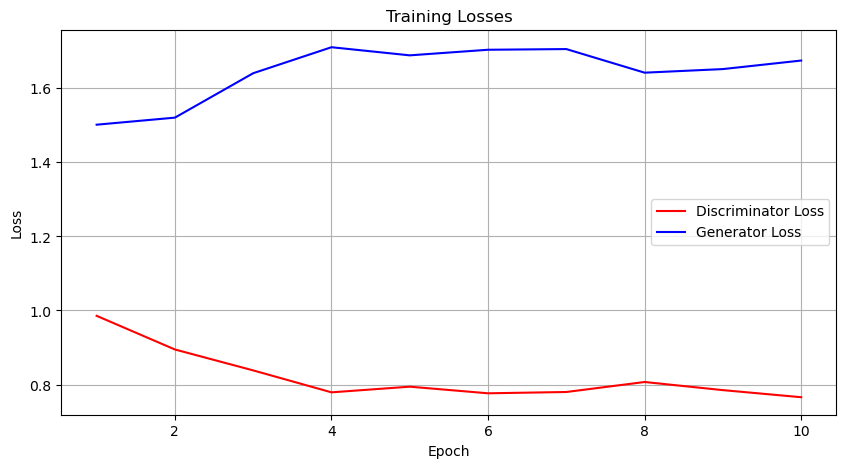

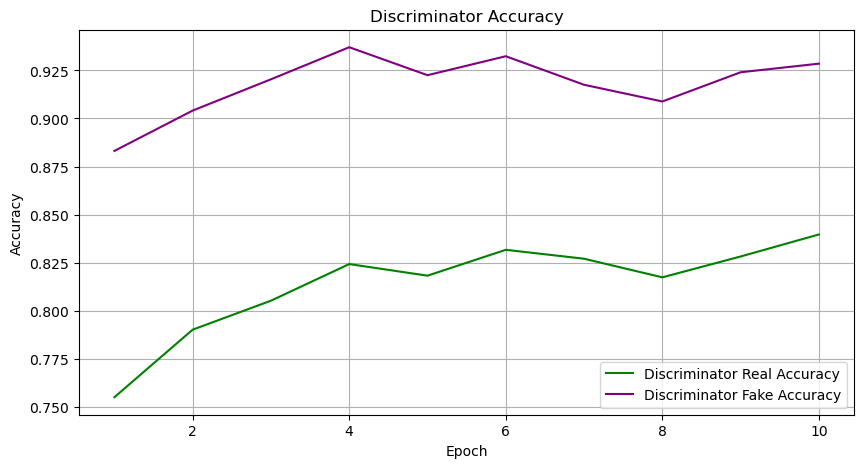

Training finished!


In [49]:
# Hyperparameters
batch_size = 128
image_size = 32
z_dim = 100
number_features = 64
number_channels = 1
number_disc_features = 64
number_of_classes = 10
lr = 0.0001
beta1 = 0.5
num_epochs=10
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

generator = Generator(z_dim, number_features, number_channels, number_of_classes).to(device)
discriminator = Discriminator(number_disc_features, number_channels, number_of_classes).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Training loop
d_losses = []
g_losses = []
d_real_accuracies = []
d_fake_accuracies = []

# For creating GIF of latent code evolution
latent_evolution_images = []
fixed_z = torch.randn(1, z_dim, 1, 1, device=device)  # Fixed latent code for generating images
fixed_label = torch.randint(0, 10, (1,), device=device)

for epoch in range(num_epochs):
    d_real_correct = 0
    d_fake_correct = 0
    d_real_total = 0
    d_fake_total = 0
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    
    for i, (real_images, labels) in enumerate(data_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        labels = labels.to(device)

        ############################
        # Train Discriminator
        ############################
        optimizer_D.zero_grad()

        # Real images
        real_output = discriminator(real_images, labels)
        d_real_loss = discriminator_loss(real_output, torch.zeros_like(real_output))
        d_real_loss.backward()

        # Fake images
        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_images = generator(z, labels).detach()
        fake_output = discriminator(fake_images, labels)
        d_fake_loss = discriminator_loss(torch.ones_like(fake_output), fake_output)
        d_fake_loss.backward()

        optimizer_D.step()

        # Compute discriminator accuracy
        d_real_correct += torch.sum(real_output > 0.5).item()
        d_fake_correct += torch.sum(fake_output < 0.5).item()
        d_real_total += real_output.size(0)
        d_fake_total += fake_output.size(0)

        # Accumulate discriminator loss for the epoch
        epoch_d_loss += d_real_loss.item() + d_fake_loss.item()

        ############################
        # Train Generator
        ############################
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        generated_images = generator(z, labels)
        g_output = discriminator(generated_images, labels)
        g_loss = generator_loss(g_output)
        g_loss.backward()

        optimizer_G.step()

        # Accumulate generator loss for the epoch
        epoch_g_loss += g_loss.item()

    # Calculate discriminator accuracy
    d_real_accuracy = d_real_correct / d_real_total
    d_fake_accuracy = d_fake_correct / d_fake_total
    d_real_accuracies.append(d_real_accuracy)
    d_fake_accuracies.append(d_fake_accuracy)

    # Calculate average losses for the epoch
    epoch_d_loss /= len(data_loader)
    epoch_g_loss /= len(data_loader)
    d_losses.append(epoch_d_loss)
    g_losses.append(epoch_g_loss)

    ############################
    # Print training information
    ############################
    print(f"Epoch [{epoch+1}/{num_epochs}], Discriminator Real Accuracy: {d_real_accuracy:.4f}, Discriminator Fake Accuracy: {d_fake_accuracy:.4f}, "
          f"D Loss: {epoch_d_loss:.4f}, G Loss: {epoch_g_loss:.4f}")

    # Save generated images
    with torch.no_grad():
        generated_images = generator(fixed_z.repeat(10, 1, 1, 1), labels[:10]).cpu()
        grid = torchvision.utils.make_grid(generated_images, nrow=10, normalize=True)
        latent_evolution_images.append((grid.permute(1, 2, 0).numpy() * 255).astype(np.uint8))

# Plotting training losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), d_losses, label='Discriminator Loss', color='red')
plt.plot(range(1, num_epochs + 1), g_losses, label='Generator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True)
plt.show()

# Plotting discriminator accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), d_real_accuracies, label='Discriminator Real Accuracy', color='green')
plt.plot(range(1, num_epochs + 1), d_fake_accuracies, label='Discriminator Fake Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Save GIF
imageio.mimsave('latent_evolution.gif', latent_evolution_images, fps=1)

print("Training finished!")



# Regarding the exercise "Use a single latent code and show the evolution of its corresponding image during training", you can see the result in the folder latent_evolution.gif file

Epoch [1/10], Loss: 0.3915
Epoch [2/10], Loss: 0.2638
Epoch [3/10], Loss: 0.2263
Epoch [4/10], Loss: 0.1990
Epoch [5/10], Loss: 0.1793
Epoch [6/10], Loss: 0.1573
Epoch [7/10], Loss: 0.1430
Epoch [8/10], Loss: 0.1285
Epoch [9/10], Loss: 0.1120
Epoch [10/10], Loss: 0.1010


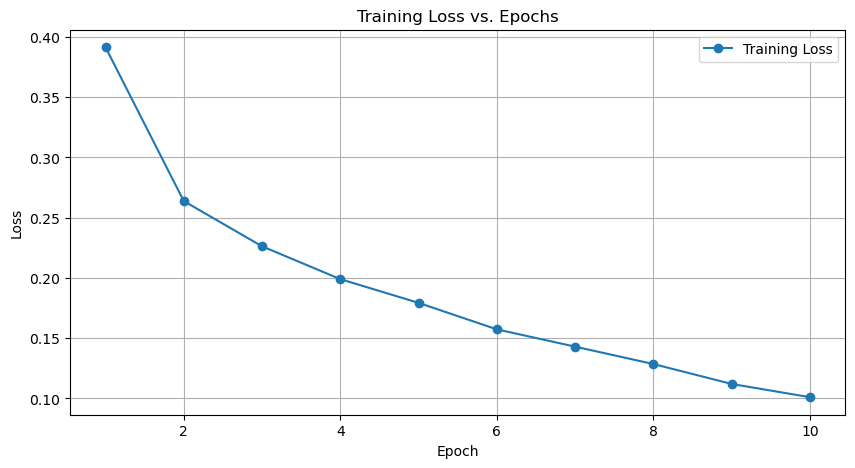

In [50]:
# Load FashionMNIST data
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Define the classifier (pretrained on FashionMNIST)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Instantiate and train the classifier
classifier = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Train the classifier
num_epochs = 10
train_losses = []
for epoch in range(num_epochs):
    classifier.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = classifier(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.grid()
plt.show()


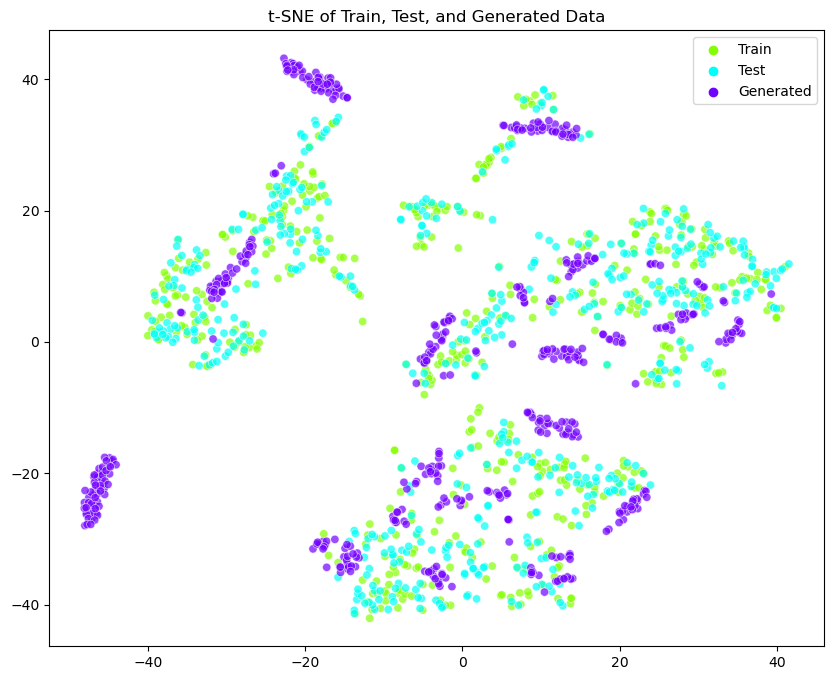

In [51]:
# Extract features from an intermediate layer
class FeatureExtractor(nn.Module):
    def __init__(self, submodel):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(submodel.features.children()))[-1]

    def forward(self, x):
        return self.features(x)

feature_extractor = FeatureExtractor(classifier).to(device)
feature_extractor.eval()

# Generate fake images using the trained generator
z_dim = 100
num_classes = 10
num_generated = 500

generator.eval()

# Generate labels for fake images
fake_labels = torch.randint(0, num_classes, (num_generated,), device=device)
noise = torch.randn(num_generated, z_dim, 1, 1, device=device)
fake_images = generator(noise, fake_labels).detach().cpu()

# Extract features from the datasets and generated data
def get_features(data_loader, model, num_samples):
    features = []
    labels = []
    for i, (images, lbls) in enumerate(data_loader):
        images = images.to(device)
        with torch.no_grad():
            feats = model(images).view(images.size(0), -1)
        features.append(feats.cpu().numpy())
        labels.append(lbls.cpu().numpy())
        if (i + 1) * data_loader.batch_size >= num_samples:
            break
    return np.concatenate(features)[:num_samples], np.concatenate(labels)[:num_samples]

# Get features for train, test, and fake images
num_samples = 500
train_features, train_labels = get_features(train_loader, feature_extractor, num_samples)
test_features, test_labels = get_features(test_loader, feature_extractor, num_samples)

with torch.no_grad():
    fake_features = feature_extractor(fake_images.to(device)).view(num_generated, -1).cpu().numpy()

# Perform t-SNE on the features
tsne = TSNE(n_components=2, random_state=42)
all_features = np.concatenate((train_features, test_features, fake_features), axis=0)
tsne_results = tsne.fit_transform(all_features)

# Prepare labels for plotting
all_labels = np.concatenate((train_labels, test_labels, fake_labels.cpu().numpy()), axis=0)
labels = ['Train'] * num_samples + ['Test'] * num_samples + ['Generated'] * num_generated

# Plot t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette=sns.color_palette("hsv", 3), alpha=0.7)
plt.title("t-SNE of Train, Test, and Generated Data")
plt.legend()
plt.show()

# Check accuracy of my generated data using the fashion mnist classifier

In [54]:
# Number of generated images
num_generated_samples = 500

# Set the generator to evaluation mode
generator.eval()

# Generate 500 images
z_dim = 100
num_classes = 10
z = torch.randn(num_generated_samples, z_dim, 1, 1, device=device)
labels = torch.randint(0, num_classes, (num_generated_samples,), device=device)
with torch.no_grad():
    generated_images = generator(z, labels)

# Set the classifier to evaluation mode
classifier.eval()

# Use the classifier to predict the labels of the generated images
with torch.no_grad():
    outputs = classifier(generated_images)
    _, predicted_labels = torch.max(outputs, 1)

# Calculate the accuracy
correct = (predicted_labels == labels).sum().item()
accuracy = correct / num_generated_samples

print(f'Accuracy of the classifier on 500 generated images: {accuracy * 100:.2f}%')


Accuracy of the classifier on 500 generated images: 83.00%


# Generate and display a few random synthesized images from the generator after training

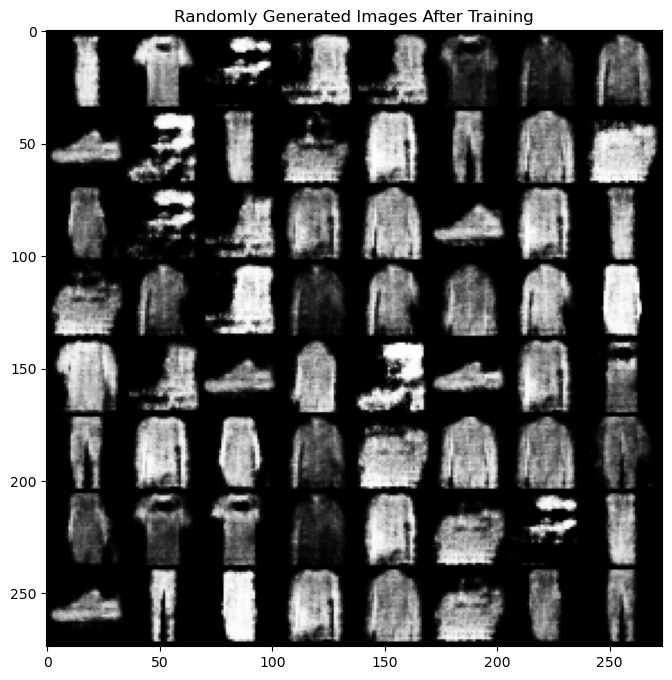

In [55]:

generator.eval()
with torch.no_grad():
    z = torch.randn(64, z_dim, 1, 1, device=device)
    labels = torch.randint(0, 10, (64,), device=device)
    generated_images = generator(z, labels)

    # Plot the images
    grid = torchvision.utils.make_grid(generated_images, nrow=8, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.title("Randomly Generated Images After Training")
    plt.show()